In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.decomposition import PCA, KernelPCA



In [2]:
# train=pd.read_csv('/kaggle/input/ames-housing-dataset/AmesHousing.csv')
test =pd.read_csv('./dataset/test.csv')
train=pd.read_csv('./dataset/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
from collections import Counter
num_col = train.loc[:,'MSSubClass':'SaleCondition'].select_dtypes(exclude=['object']).columns
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.7 * IQR ## increased to 1.7
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers 
Outliers_to_drop = detect_outliers(train,2, num_col)
train.loc[Outliers_to_drop].["Id"].count() # Show the outliers rows

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
93,94,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,133900
125,126,190,RM,60.0,6780,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,84500
165,166,190,RL,62.0,10106,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,127500
246,247,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,137000
291,292,190,RL,55.0,5687,Pave,Grvl,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,135900
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
344,345,160,RM,36.0,2592,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,85000
504,505,160,RL,24.0,2308,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,147000
520,521,190,RL,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,106250


In [4]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
print('Outliers dropped')

Outliers dropped


In [5]:
df = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))
print('Concatenation of train and test datasets finished')

Concatenation of train and test datasets finished


In [6]:
df['MSZoning'].fillna('N')
df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace = True)
df['Alley'].fillna('N')
df['Exterior1st'].fillna('N')
df['Exterior2nd'].fillna('N')
df['Utilities'].fillna('N')
df['MasVnrType'].fillna('N')
df['BsmtFullBath'].fillna(0)
df['BsmtHalfBath'].fillna(0)
df['FullBath'].fillna(0)
df['HalfBath'].fillna(0)
df['KitchenQual'].fillna('N')
df['Functional'].fillna('N')
df['FireplaceQu'].fillna('N')
df['GarageType'].fillna('N')
df['GarageYrBlt'].fillna(0,inplace=True)
df['GarageFinish'].fillna('N')
df['GarageCars'].fillna(0)
df['GarageArea'].fillna(0,inplace=True)
df['GarageQual'].fillna('N')
df['GarageCond'].fillna('N')
df['BsmtFinSF2'].fillna(0,inplace=True)
df['MasVnrArea'].fillna(0,inplace=True)
df['BsmtFinSF1'].fillna(0,inplace=True)
df['SaleType'].fillna('N')
df['BsmtUnfSF'].fillna(0,inplace=True)
df['TotalBsmtSF'].fillna(0,inplace=True)
df['PoolQC'].fillna('N')
df['Fence'].fillna('N')
df['MiscFeature'].fillna('N')
df['BsmtQual'].fillna('N')
df['BsmtCond'].fillna('N')
df['BsmtExposure'].fillna('N')
df['BsmtFinType1'].fillna('N')
df['BsmtFinType2'].fillna('N')
df['Electrical'].fillna('N')
df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
df['Area'] = df['LotArea']*df['LotFrontage']
df['Area_log'] = np.log1p(df['Area'])

def Gar_category(cat):
    if cat <= 250:
        return 1
    elif cat <= 500 and cat > 250:
        return 2
    elif cat <= 1000 and cat > 500:
        return 3
    return 4
df['GarageArea_cat'] = df['GarageArea'].apply(Gar_category)

def Low_category(cat):
    if cat <= 1000:
        return 1
    elif cat <= 2000 and cat > 1000:
        return 2
    elif cat <= 3000 and cat > 2000:
        return 3
    return 4
df['GrLivArea_cat'] = df['GrLivArea'].apply(Low_category)

def fl1_category(cat):
    if cat <= 500:
        return 1
    elif cat <= 1000 and cat > 500:
        return 2
    elif cat <= 1500 and cat > 1000:
        return 3
    elif cat <= 2000 and cat > 1500:
        return 4
    return 5
df['1stFlrSF_cat'] = df['1stFlrSF'].apply(fl1_category)
df['2ndFlrSF_cat'] = df['2ndFlrSF'].apply(fl1_category)

def bsmtt_category(cat):
    if cat <= 500:
        return 1
    elif cat <= 1000 and cat > 500:
        return 2
    elif cat <= 1500 and cat > 1000:
        return 3
    elif cat <= 2000 and cat > 1500:
        return 4
    return 5
df['TotalBsmtSF_cat'] = df['TotalBsmtSF'].apply(bsmtt_category)

def bsmt_category(cat):
    if cat <= 500:
        return 1
    elif cat <= 1000 and cat > 500:
        return 2
    elif cat <= 1500 and cat > 1000:
        return 3
    elif cat <= 2000 and cat > 1500:
        return 4
    return 5
df['BsmtUnfSF_cat'] = df['BsmtUnfSF'].apply(bsmt_category)

def lot_category(cat):
    if cat <= 50:
        return 1
    elif cat <= 100 and cat > 50:
        return 2
    elif cat <= 150 and cat > 100:
        return 3
    return 4
df['LotFrontage_cat'] = df['LotFrontage'].apply(lot_category)

def lot_category1(cat):
    if cat <= 5000:
        return 1
    elif cat <= 10000 and cat > 5000:
        return 2
    elif cat <= 15000 and cat > 10000:
        return 3
    elif cat <= 20000 and cat > 15000:
        return 4
    elif cat <= 25000 and cat > 20000:
        return 5
    return 6
df['LotArea_cat'] = df['LotArea'].apply(lot_category1)

def year_category(yb):
    if yb <= 1910:
        return 1
    elif yb <= 1950 and yb > 1910:
        return 2
    elif yb >= 1950 and yb < 1980:
        return 3
    elif yb >= 1980 and yb < 2000:
        return 4
    return 5



df['YearBuilt_cat'] = df['YearBuilt'].apply(year_category) 
df['YearRemodAdd_cat'] = df['YearRemodAdd'].apply(year_category)
df['GarageYrBlt_cat'] = df['GarageYrBlt'].apply(year_category)

def vnr_category(cat):
    if cat <= 250:
        return 1
    elif cat <= 500 and cat > 250:
        return 2
    elif cat <= 750 and cat > 500:
        return 3
    return 4

df['MasVnrArea_cat'] = df['MasVnrArea'].apply(vnr_category)

def allsf_category(yb):
    if yb <= 1000:
        return 1
    elif yb <= 2000 and yb > 1000:
        return 2
    elif yb >= 3000 and yb < 2000:
        return 3
    elif yb >= 4000 and yb < 3000:
        return 4
    elif yb >= 5000 and yb < 4000:
        return 5
    elif yb >= 6000 and yb < 5000:
        return 6
    return 7
df['AllSF_cat'] = df['AllSF'].apply(allsf_category)

In [7]:

dummy_col=['OverallQual', 'AllSF_cat', 'MiscVal','OverallCond', 'BsmtFinType2', 'SaleCondition','SaleType', 'YrSold', 'MoSold', 'MiscFeature', 'Fence', 'PoolQC', 'PoolArea', 'PavedDrive', 'GarageCond', 'GarageQual', 'GarageArea_cat', 'GarageCars', 'GarageFinish', 'GarageType', 'FireplaceQu', 'Fireplaces','Functional', 'TotRmsAbvGrd', 'KitchenQual', 'KitchenAbvGr', 'BedroomAbvGr', 'HalfBath', 'FullBath', 'BsmtHalfBath', 'BsmtFullBath','GrLivArea_cat','MSSubClass', 'MSZoning', 'LotFrontage_cat', 'LotArea_cat', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
          'BldgType', 'HouseStyle', 'YearBuilt_cat', 'YearRemodAdd_cat', 'RoofStyle', 'RoofMatl', 'Exterior2nd', 'Exterior1st', 'MasVnrType', 'MasVnrArea_cat', 'ExterQual', 'ExterCond', 'Foundation', 
          'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtUnfSF_cat', 'TotalBsmtSF_cat', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF_cat', '2ndFlrSF_cat']
df = pd.get_dummies(df, columns=dummy_col, drop_first=False)

df['LotFrontage_log'] = np.log1p(df['LotFrontage'])
df['LotArea_log'] = np.log1p(df['LotArea'])
df['BsmtUnfSF_log'] = np.log1p(df['BsmtUnfSF'])

df['Is_MasVnr'] = [1 if i != 0 else 0 for i in df['MasVnrArea']]
df['Is_BsmtFinSF1'] = [1 if i != 0 else 0 for i in df['BsmtFinSF1']]
df['Is_BsmtFinSF2'] = [1 if i != 0 else 0 for i in df['BsmtFinSF2']]
df['Is_BsmtUnfSF'] = [1 if i != 0 else 0 for i in df['BsmtUnfSF']]
df['Is_TotalBsmtSF'] = [1 if i != 0 else 0 for i in df['TotalBsmtSF']]
df['Is_2ndFlrSF'] = [1 if i != 0 else 0 for i in df['2ndFlrSF']]
df['Is_LowQualFinSF'] = [1 if i != 0 else 0 for i in df['LowQualFinSF']]
df['Is_GarageArea'] = [1 if i != 0 else 0 for i in df['GarageArea']]
df['Is_WoodDeckSF'] = [1 if i != 0 else 0 for i in df['WoodDeckSF']]
df['Is_OpenPorchSF'] = [1 if i != 0 else 0 for i in df['OpenPorchSF']]
df['Is_EnclosedPorch'] = [1 if i != 0 else 0 for i in df['EnclosedPorch']]
df['Is_3SsnPorch'] = [1 if i != 0 else 0 for i in df['3SsnPorch']]
df['Is_ScreenPorch'] = [1 if i != 0 else 0 for i in df['ScreenPorch']]



print('finished')

finished


In [8]:
df.shape

(2815, 485)

In [9]:
def descrictive_stat_feat(df):
    df = pd.DataFrame(df)
    dcol= [c for c in df.columns if df[c].nunique()>=10]
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    q1 = df[dcol].apply(np.float32).quantile(0.25)
    q3 = df[dcol].apply(np.float32).quantile(0.75)
    
    #Add mean and median column to data set having more then 10 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].astype(np.float32).values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].astype(np.float32).values > d_mean[c]).astype(np.int8)
        df[c+str('_q1')] = (df[c].astype(np.float32).values < q1[c]).astype(np.int8)
        df[c+str('_q3')] = (df[c].astype(np.float32).values > q3[c]).astype(np.int8)
    return df

df = descrictive_stat_feat(df)

In [10]:
#creating matrices for feature selection:
X_train = df[:train.shape[0]]
X_test_fin = df[train.shape[0]:]
y = train.SalePrice
X_train['Y'] = y
df = X_train
print('finished')

finished


In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


X = df.drop('Y', axis=1)
y = df.Y

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)


# sc = MinMaxScaler(feature_range=(-1, 1))
# x_train = sc.fit_transform(x_train)
# x_valid = sc.fit_transform(x_valid)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(X_test_fin)



params = {
        'objective':'reg:linear',
#         'n_estimators': 50,
        'booster':'gbtree',
        'max_depth':2,
        'eval_metric':'rmse',
        'learning_rate':0.1, 
        'min_child_weight':1,
        'subsample':0.80,
        'colsample_bytree':0.81,
        'seed':45,
        'reg_alpha':1,#1e-03,
        'reg_lambda':0,
        'gamma':0,
        'nthread':-1

}


watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 2000,  watchlist, early_stopping_rounds=300, maximize=False, verbose_eval=10)

p_test = clf.predict(d_test)

[02:54:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:175211.35938	valid-rmse:168190.35938
[10]	train-rmse:69540.69531	valid-rmse:65249.33594
[20]	train-rmse:36492.90625	valid-rmse:34425.83594
[30]	train-rmse:26843.50781	valid-rmse:25973.08008
[40]	train-rmse:23470.96289	valid-rmse:23442.75000
[50]	train-rmse:21681.42188	valid-rmse:22151.72461
[60]	train-rmse:20403.56250	valid-rmse:21584.62695
[70]	train-rmse:19427.85742	valid-rmse:20883.48633
[80]	train-rmse:18630.24219	valid-rmse:20251.41016
[90]	train-rmse:17976.46484	valid-rmse:19829.18945
[100]	train-rmse:17436.64844	valid-rmse:19453.49805
[110]	train-rmse:16823.33594	valid-rmse:19087.06055
[120]	train-rmse:16334.46875	valid-rmse:19018.83398
[130]	train-rmse:15973.29102	valid-rmse:18969.74609
[140]	train-rmse:15534.42383	valid-rmse:18684.44141
[150]	train-rmse:15198.46973	valid-rmse:18601.24609


In [12]:
from sklearn.metrics import mean_absolute_error, r2_score
d_test = clf.predict(d_valid)
r2_score(y_valid, d_test)

0.9349093722314933

In [13]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = p_test
sub

,Id,SalePrice
0,1461,128654.914062
1,1462,164788.312500
2,1463,199307.109375
3,1464,206243.453125
4,1465,192305.031250
...,...,...
1454,2915,81399.820312
1455,2916,61472.992188
1456,2917,125608.867188
1457,2918,121767.335938


In [14]:
sub.to_csv("lkh_gboost3.csv", index=False)

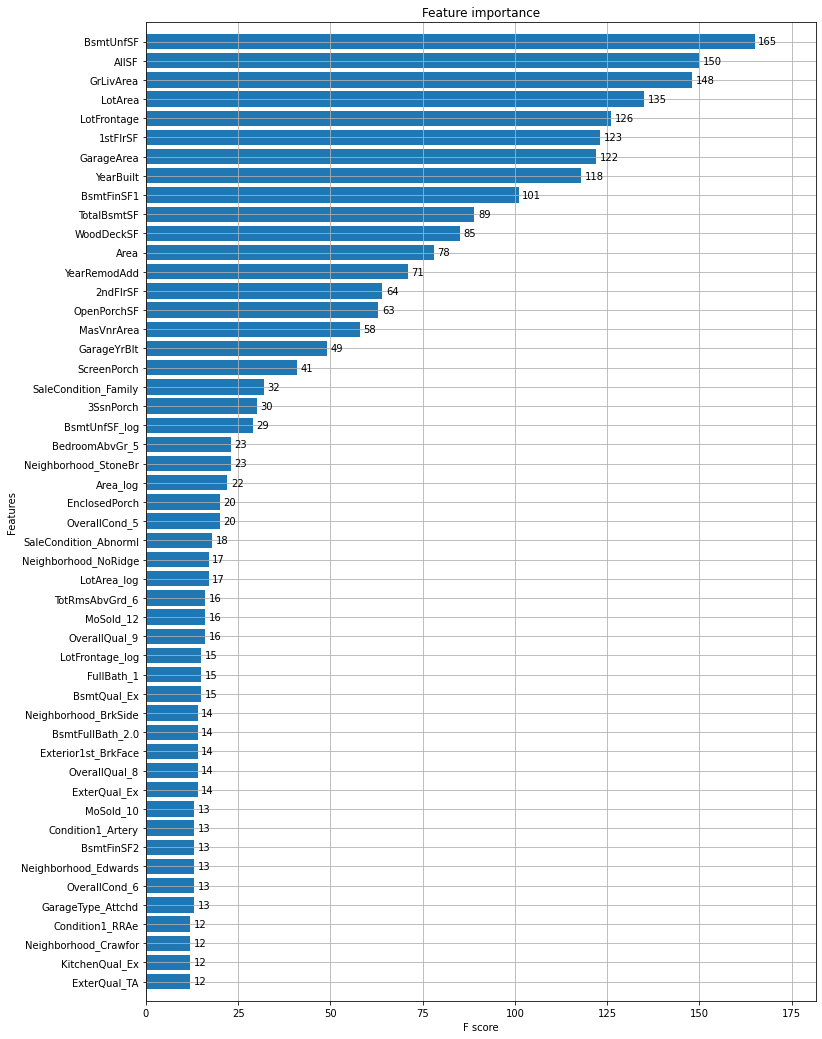

In [15]:
import matplotlib.pyplot as plt
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
plt.show()